# The multi-armed bandit problem

Prof. Dr. Mike Espig, WHZ – University of Applied Sciences Zwickau



### Table of Contents

* [The homework/practicum](#practicum) 




In [6]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

<a id="practicum"></a>
## The homework/practicum

<font color=green> **Exercise 1:** Complete the following Python code to solve the multi-armed bandit problem. Meanwhile, during that process, you will find some useful instructions.</font>



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

- Let true arm values be normally distributed with mean of 0, variance of 1
- Add a noise term to each reward, also normally distributed with mean of 0, variance of 1

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numpy.random import RandomState
import warnings

class Bandit:
    def __init__(self, n_arms: int = 10, eps: float = 0.1, dtype=None, seed: bool = None):
        self.n_arms = n_arms
        self.eps = eps
        self.dtype = np.float16 if dtype is None else dtype
        self.seed = seed
        self.N = np.zeros(n_arms)
        self.Q = np.zeros(n_arms)
        self.action_means = np.random.normal(size=(self.n_arms,), scale=1.0)

    def get_reward(self, action, pull):
        if self.seed: np.random.seed(pull)
        reward = np.random.normal(loc=self.action_means, size=self.n_arms)
        # print('reward: ', reward)

        if self.seed: np.random.seed(pull)
        noise = np.random.randn(self.n_arms)

        reward = reward + noise
        return reward[action]

    def get_action(self, pull=None):
        if self.seed: np.random.seed(pull)
        if np.random.rand() > self.eps and np.any(self.Q):
            action = np.argmax(self.Q)
        else:
            action = np.random.randint(0, self.n_arms)
        return action

    def update_Q(self, action, reward):
        self.N[action] += 1
        self.Q[action] += 1 / self.N[action] * (reward - self.Q[action])
        return self.Q[action]

    def experiment(self, n_pulls: int):
        """Run experiment n_pulls times. Updates return Q on each iteration.

        Args:
            n_pulls (int): number of pulls

        Returns: numpy array of shape (n_pulls, n_arms)
        """
        self.N = np.zeros(self.n_arms)
        self.Q = np.zeros(self.n_arms)
        Q_history = np.array([])

        for pull in range(n_pulls):
            action = self.get_action(pull)
            reward = self.get_reward(action, pull)
            Q = self.update_Q(action, reward).copy().astype(self.dtype)
            Q_history = np.append(Q_history, Q)

        print(Q_history)
        return Q_history.reshape((n_pulls,))

    def experiments(self, n_exp, n_pulls, threads=None):
        if self.seed:
            warnings.warn(f'seed should be set to False in order to run independent experiments')

        def iterate(n_exp):
            experiments = np.zeros((n_pulls,))
            for i in range(n_exp):
                experiments += self.experiment(n_pulls)
            return experiments

        if threads:
            n_exp_list = [n_exp // threads] * threads
            n_exp_list[0] += n_exp % threads
            result = Parallel(n_jobs=threads)(
                delayed(iterate)(n_exp) for n_exp in n_exp_list
            )
            experiments = sum(result)
        else:
            experiments = iterate(n_exp)

        return experiments / np.float(n_exp)


# bandit = Bandit(n_arms=4, seed=0)
# bandit.experiment(5)
# experiments = bandit.experiments(5, 5)
# print(experiments)

A single experiment consists of pulling the arm n_pulls times for a given 10 armed bandit. Store the reward $r_t$ in a list called history and return this list.

Repeat experiment many times and look at the evolution of the rewards, averaged over all the experiments

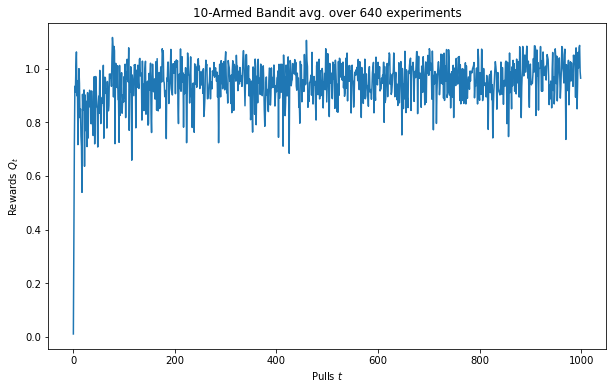

Wall time: 5.98 s


In [16]:
%%time
n_exp = 640
n_pulls = 1000
arms = 10
eps = 0.1

fig = plt.figure(figsize=(10,6))
plt.title(f'{arms}-Armed Bandit avg. over {n_exp} experiments')
plt.plot(Bandit(arms, eps).experiments(n_exp, n_pulls, threads=16))
ax = plt.gca()
plt.ylabel('Rewards $Q_t$')
plt.xlabel('Pulls $t$')
plt.show()

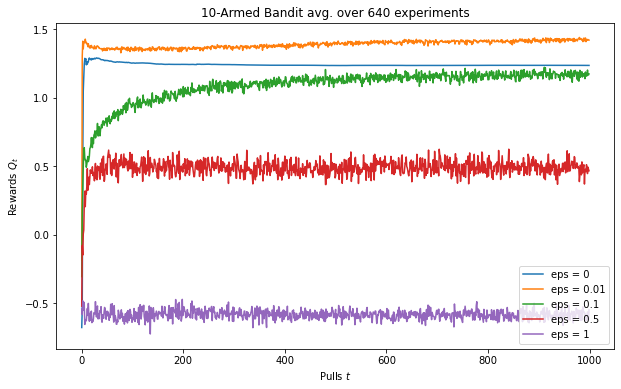

Wall time: 40.9 s


In [18]:
%%time
n_exp = 640
n_pulls = 1000
epss = [0, 0.01, 0.1, 0.5, 1]
arms = 10

fig = plt.figure(figsize=(10,6))
plt.title(f'{arms}-Armed Bandit avg. over {n_exp} experiments')
for eps in epss: 
    plt.plot(Bandit(arms, eps).experiments(n_exp, n_pulls, threads=16), label=f"eps = {eps}")
plt.legend(loc='upper right')
plt.ylabel('Rewards $Q_t$')
plt.xlabel('Pulls $t$')
plt.legend()
plt.show()